In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

### Dados
- são carregados os dados pre-procesados no notebook: <i>Data pre-processing</i>

In [4]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [5]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [6]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [7]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [8]:
np.min(X_rg)

BB9     5.692781
BB10    5.733848
BB17    5.686571
BB19    5.735536
BB20    6.016590
BB21    6.131968
BB11    6.113390
BB12    5.891730
BB18    5.822536
dtype: float64

In [9]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [10]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [11]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4168, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [12]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.1))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [13]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [14]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [15]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [96]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall

In [103]:
noise_input = 50
ep = 2500
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_19 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


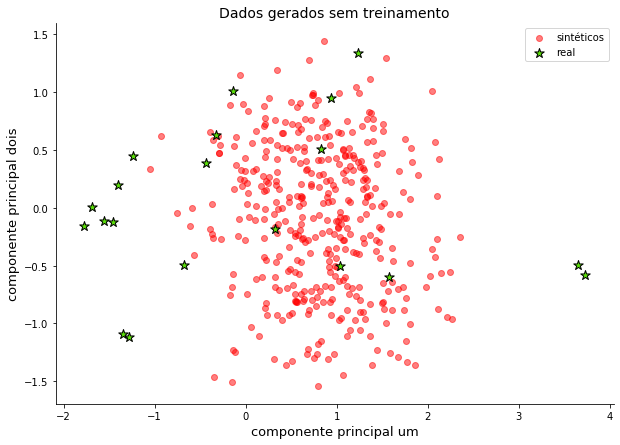

In [104]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [105]:
g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/2500] [Discriminator::d_loss: 0.717626],[Generator::loss: 0.785785], 1.749777[sec]
epoch:[2/2500] [Discriminator::d_loss: 0.674742],[Generator::loss: 0.767331], 0.019461[sec]
epoch:[3/2500] [Discriminator::d_loss: 0.717619],[Generator::loss: 0.775275], 0.016053[sec]
epoch:[4/2500] [Discriminator::d_loss: 0.711601],[Generator::loss: 0.788051], 0.015323[sec]
epoch:[5/2500] [Discriminator::d_loss: 0.685534],[Generator::loss: 0.868286], 0.016823[sec]
epoch:[6/2500] [Discriminator::d_loss: 0.701073],[Generator::loss: 0.725031], 0.015831[sec]
epoch:[7/2500] [Discriminator::d_loss: 0.700416],[Generator::loss: 0.837054], 0.015635[sec]
epoch:[8/2500] [Discriminator::d_loss: 0.712480],[Generator::loss: 0.785978], 0.016703[sec]
epoch:[9/2500] [Discriminator::d_loss: 0.726169],[Generator::loss: 0.788528], 0.016185[sec]
epoch:[10/2500] [Discriminator::d_loss: 0.703717],[Generator::loss: 0.779122], 0.015793[sec]
epoch:[11/2500] [Discriminator::d_loss: 0.691676],[Generator::loss: 0.807357], 

epoch:[91/2500] [Discriminator::d_loss: 0.641516],[Generator::loss: 0.785809], 0.019252[sec]
epoch:[92/2500] [Discriminator::d_loss: 0.614380],[Generator::loss: 0.778369], 0.020775[sec]
epoch:[93/2500] [Discriminator::d_loss: 0.632171],[Generator::loss: 0.755792], 0.027802[sec]
epoch:[94/2500] [Discriminator::d_loss: 0.651842],[Generator::loss: 0.733702], 0.016652[sec]
epoch:[95/2500] [Discriminator::d_loss: 0.646480],[Generator::loss: 0.802987], 0.015932[sec]
epoch:[96/2500] [Discriminator::d_loss: 0.622087],[Generator::loss: 0.834188], 0.015630[sec]
epoch:[97/2500] [Discriminator::d_loss: 0.644696],[Generator::loss: 0.745201], 0.015265[sec]
epoch:[98/2500] [Discriminator::d_loss: 0.667706],[Generator::loss: 0.819031], 0.016450[sec]
epoch:[99/2500] [Discriminator::d_loss: 0.638189],[Generator::loss: 0.751704], 0.016177[sec]
epoch:[100/2500] [Discriminator::d_loss: 0.646069],[Generator::loss: 0.763485], 0.015474[sec]
epoch:[101/2500] [Discriminator::d_loss: 0.650019],[Generator::loss: 

epoch:[187/2500] [Discriminator::d_loss: 0.628064],[Generator::loss: 0.784665], 0.015502[sec]
epoch:[188/2500] [Discriminator::d_loss: 0.615411],[Generator::loss: 0.819876], 0.019169[sec]
epoch:[189/2500] [Discriminator::d_loss: 0.623720],[Generator::loss: 0.820262], 0.021832[sec]
epoch:[190/2500] [Discriminator::d_loss: 0.636077],[Generator::loss: 0.809377], 0.017746[sec]
epoch:[191/2500] [Discriminator::d_loss: 0.635443],[Generator::loss: 0.772378], 0.016665[sec]
epoch:[192/2500] [Discriminator::d_loss: 0.629156],[Generator::loss: 0.854488], 0.015569[sec]
epoch:[193/2500] [Discriminator::d_loss: 0.609735],[Generator::loss: 0.868616], 0.016237[sec]
epoch:[194/2500] [Discriminator::d_loss: 0.610347],[Generator::loss: 0.790074], 0.015553[sec]
epoch:[195/2500] [Discriminator::d_loss: 0.583535],[Generator::loss: 0.788827], 0.015536[sec]
epoch:[196/2500] [Discriminator::d_loss: 0.616277],[Generator::loss: 0.810594], 0.017279[sec]
epoch:[197/2500] [Discriminator::d_loss: 0.588019],[Generato

epoch:[277/2500] [Discriminator::d_loss: 0.580485],[Generator::loss: 0.783545], 0.022829[sec]
epoch:[278/2500] [Discriminator::d_loss: 0.560145],[Generator::loss: 0.864708], 0.019150[sec]
epoch:[279/2500] [Discriminator::d_loss: 0.639041],[Generator::loss: 0.762878], 0.018451[sec]
epoch:[280/2500] [Discriminator::d_loss: 0.580371],[Generator::loss: 0.755915], 0.018739[sec]
epoch:[281/2500] [Discriminator::d_loss: 0.600702],[Generator::loss: 0.743264], 0.015542[sec]
epoch:[282/2500] [Discriminator::d_loss: 0.606382],[Generator::loss: 0.747600], 0.015661[sec]
epoch:[283/2500] [Discriminator::d_loss: 0.619721],[Generator::loss: 0.847277], 0.015457[sec]
epoch:[284/2500] [Discriminator::d_loss: 0.629957],[Generator::loss: 0.808266], 0.015540[sec]
epoch:[285/2500] [Discriminator::d_loss: 0.612875],[Generator::loss: 0.801863], 0.018136[sec]
epoch:[286/2500] [Discriminator::d_loss: 0.646053],[Generator::loss: 0.771300], 0.015868[sec]
epoch:[287/2500] [Discriminator::d_loss: 0.638388],[Generato

epoch:[377/2500] [Discriminator::d_loss: 0.623421],[Generator::loss: 0.860537], 0.018176[sec]
epoch:[378/2500] [Discriminator::d_loss: 0.605826],[Generator::loss: 0.814519], 0.018263[sec]
epoch:[379/2500] [Discriminator::d_loss: 0.608438],[Generator::loss: 0.764690], 0.016556[sec]
epoch:[380/2500] [Discriminator::d_loss: 0.596582],[Generator::loss: 0.885303], 0.016851[sec]
epoch:[381/2500] [Discriminator::d_loss: 0.623572],[Generator::loss: 0.843198], 0.015664[sec]
epoch:[382/2500] [Discriminator::d_loss: 0.579892],[Generator::loss: 0.796365], 0.015811[sec]
epoch:[383/2500] [Discriminator::d_loss: 0.631950],[Generator::loss: 0.754748], 0.015477[sec]
epoch:[384/2500] [Discriminator::d_loss: 0.630136],[Generator::loss: 0.845724], 0.015601[sec]
epoch:[385/2500] [Discriminator::d_loss: 0.639431],[Generator::loss: 0.882375], 0.015846[sec]
epoch:[386/2500] [Discriminator::d_loss: 0.601423],[Generator::loss: 0.834885], 0.016276[sec]
epoch:[387/2500] [Discriminator::d_loss: 0.572324],[Generato

epoch:[466/2500] [Discriminator::d_loss: 0.567583],[Generator::loss: 0.819696], 0.020497[sec]
epoch:[467/2500] [Discriminator::d_loss: 0.578280],[Generator::loss: 0.818613], 0.018218[sec]
epoch:[468/2500] [Discriminator::d_loss: 0.607166],[Generator::loss: 0.831973], 0.016867[sec]
epoch:[469/2500] [Discriminator::d_loss: 0.563980],[Generator::loss: 0.875716], 0.017142[sec]
epoch:[470/2500] [Discriminator::d_loss: 0.603963],[Generator::loss: 0.835936], 0.016434[sec]
epoch:[471/2500] [Discriminator::d_loss: 0.610181],[Generator::loss: 0.866210], 0.015620[sec]
epoch:[472/2500] [Discriminator::d_loss: 0.631164],[Generator::loss: 0.847800], 0.015312[sec]
epoch:[473/2500] [Discriminator::d_loss: 0.623617],[Generator::loss: 0.873025], 0.015558[sec]
epoch:[474/2500] [Discriminator::d_loss: 0.578334],[Generator::loss: 0.846761], 0.015775[sec]
epoch:[475/2500] [Discriminator::d_loss: 0.570451],[Generator::loss: 0.890636], 0.015510[sec]
epoch:[476/2500] [Discriminator::d_loss: 0.584323],[Generato

epoch:[558/2500] [Discriminator::d_loss: 0.588639],[Generator::loss: 0.794344], 0.021652[sec]
epoch:[559/2500] [Discriminator::d_loss: 0.594448],[Generator::loss: 0.900139], 0.027662[sec]
epoch:[560/2500] [Discriminator::d_loss: 0.592407],[Generator::loss: 0.866527], 0.028217[sec]
epoch:[561/2500] [Discriminator::d_loss: 0.614031],[Generator::loss: 0.900715], 0.021960[sec]
epoch:[562/2500] [Discriminator::d_loss: 0.564776],[Generator::loss: 0.895140], 0.019820[sec]
epoch:[563/2500] [Discriminator::d_loss: 0.627623],[Generator::loss: 0.847387], 0.018624[sec]
epoch:[564/2500] [Discriminator::d_loss: 0.573442],[Generator::loss: 0.893487], 0.017905[sec]
epoch:[565/2500] [Discriminator::d_loss: 0.559220],[Generator::loss: 0.825043], 0.020066[sec]
epoch:[566/2500] [Discriminator::d_loss: 0.592834],[Generator::loss: 0.898494], 0.016432[sec]
epoch:[567/2500] [Discriminator::d_loss: 0.596168],[Generator::loss: 0.778688], 0.017854[sec]
epoch:[568/2500] [Discriminator::d_loss: 0.583199],[Generato

epoch:[655/2500] [Discriminator::d_loss: 0.593356],[Generator::loss: 0.891405], 0.021161[sec]
epoch:[656/2500] [Discriminator::d_loss: 0.608999],[Generator::loss: 0.830705], 0.023156[sec]
epoch:[657/2500] [Discriminator::d_loss: 0.554748],[Generator::loss: 0.874781], 0.027192[sec]
epoch:[658/2500] [Discriminator::d_loss: 0.564491],[Generator::loss: 0.933169], 0.022421[sec]
epoch:[659/2500] [Discriminator::d_loss: 0.583491],[Generator::loss: 0.883091], 0.022413[sec]
epoch:[660/2500] [Discriminator::d_loss: 0.571621],[Generator::loss: 0.896085], 0.028621[sec]
epoch:[661/2500] [Discriminator::d_loss: 0.545215],[Generator::loss: 0.837311], 0.026407[sec]
epoch:[662/2500] [Discriminator::d_loss: 0.597573],[Generator::loss: 0.898129], 0.019720[sec]
epoch:[663/2500] [Discriminator::d_loss: 0.565327],[Generator::loss: 0.904961], 0.021744[sec]
epoch:[664/2500] [Discriminator::d_loss: 0.563464],[Generator::loss: 0.945658], 0.024304[sec]
epoch:[665/2500] [Discriminator::d_loss: 0.589971],[Generato

epoch:[748/2500] [Discriminator::d_loss: 0.576109],[Generator::loss: 0.912179], 0.017337[sec]
epoch:[749/2500] [Discriminator::d_loss: 0.566582],[Generator::loss: 0.940615], 0.022936[sec]
epoch:[750/2500] [Discriminator::d_loss: 0.575650],[Generator::loss: 0.903653], 0.018203[sec]
epoch:[751/2500] [Discriminator::d_loss: 0.627452],[Generator::loss: 0.932545], 0.016151[sec]
epoch:[752/2500] [Discriminator::d_loss: 0.612422],[Generator::loss: 0.843152], 0.017410[sec]
epoch:[753/2500] [Discriminator::d_loss: 0.588645],[Generator::loss: 0.883376], 0.016865[sec]
epoch:[754/2500] [Discriminator::d_loss: 0.605552],[Generator::loss: 0.880828], 0.015681[sec]
epoch:[755/2500] [Discriminator::d_loss: 0.591761],[Generator::loss: 0.954970], 0.015891[sec]
epoch:[756/2500] [Discriminator::d_loss: 0.569187],[Generator::loss: 0.886425], 0.015707[sec]
epoch:[757/2500] [Discriminator::d_loss: 0.609958],[Generator::loss: 0.892857], 0.015613[sec]
epoch:[758/2500] [Discriminator::d_loss: 0.599386],[Generato

epoch:[845/2500] [Discriminator::d_loss: 0.610191],[Generator::loss: 0.873909], 0.017324[sec]
epoch:[846/2500] [Discriminator::d_loss: 0.604007],[Generator::loss: 0.948648], 0.028114[sec]
epoch:[847/2500] [Discriminator::d_loss: 0.627631],[Generator::loss: 0.865585], 0.017267[sec]
epoch:[848/2500] [Discriminator::d_loss: 0.580528],[Generator::loss: 0.920804], 0.016271[sec]
epoch:[849/2500] [Discriminator::d_loss: 0.640096],[Generator::loss: 0.955072], 0.016428[sec]
epoch:[850/2500] [Discriminator::d_loss: 0.553225],[Generator::loss: 0.837615], 0.016073[sec]
epoch:[851/2500] [Discriminator::d_loss: 0.616467],[Generator::loss: 0.891324], 0.017108[sec]
epoch:[852/2500] [Discriminator::d_loss: 0.595320],[Generator::loss: 0.929401], 0.017204[sec]
epoch:[853/2500] [Discriminator::d_loss: 0.633614],[Generator::loss: 0.894648], 0.015949[sec]
epoch:[854/2500] [Discriminator::d_loss: 0.638751],[Generator::loss: 0.822961], 0.015920[sec]
epoch:[855/2500] [Discriminator::d_loss: 0.621957],[Generato

epoch:[943/2500] [Discriminator::d_loss: 0.647546],[Generator::loss: 0.912107], 0.024017[sec]
epoch:[944/2500] [Discriminator::d_loss: 0.625510],[Generator::loss: 0.856560], 0.021100[sec]
epoch:[945/2500] [Discriminator::d_loss: 0.591489],[Generator::loss: 0.908801], 0.016306[sec]
epoch:[946/2500] [Discriminator::d_loss: 0.641673],[Generator::loss: 0.873466], 0.015684[sec]
epoch:[947/2500] [Discriminator::d_loss: 0.637614],[Generator::loss: 0.873760], 0.015535[sec]
epoch:[948/2500] [Discriminator::d_loss: 0.603725],[Generator::loss: 0.857949], 0.015596[sec]
epoch:[949/2500] [Discriminator::d_loss: 0.637948],[Generator::loss: 0.819209], 0.015608[sec]
epoch:[950/2500] [Discriminator::d_loss: 0.676370],[Generator::loss: 0.854413], 0.015984[sec]
epoch:[951/2500] [Discriminator::d_loss: 0.602085],[Generator::loss: 0.875130], 0.017802[sec]
epoch:[952/2500] [Discriminator::d_loss: 0.636093],[Generator::loss: 0.941121], 0.016846[sec]
epoch:[953/2500] [Discriminator::d_loss: 0.611538],[Generato

epoch:[1039/2500] [Discriminator::d_loss: 0.648698],[Generator::loss: 0.811873], 0.017010[sec]
epoch:[1040/2500] [Discriminator::d_loss: 0.635408],[Generator::loss: 0.835467], 0.022195[sec]
epoch:[1041/2500] [Discriminator::d_loss: 0.655287],[Generator::loss: 0.835054], 0.017459[sec]
epoch:[1042/2500] [Discriminator::d_loss: 0.641650],[Generator::loss: 0.866748], 0.016885[sec]
epoch:[1043/2500] [Discriminator::d_loss: 0.695844],[Generator::loss: 0.853264], 0.017731[sec]
epoch:[1044/2500] [Discriminator::d_loss: 0.690473],[Generator::loss: 0.862704], 0.016445[sec]
epoch:[1045/2500] [Discriminator::d_loss: 0.639159],[Generator::loss: 0.843703], 0.015628[sec]
epoch:[1046/2500] [Discriminator::d_loss: 0.707537],[Generator::loss: 0.823998], 0.015574[sec]
epoch:[1047/2500] [Discriminator::d_loss: 0.642352],[Generator::loss: 0.881788], 0.015364[sec]
epoch:[1048/2500] [Discriminator::d_loss: 0.629348],[Generator::loss: 0.793285], 0.015571[sec]
epoch:[1049/2500] [Discriminator::d_loss: 0.708806

epoch:[1133/2500] [Discriminator::d_loss: 0.682891],[Generator::loss: 0.824174], 0.020384[sec]
epoch:[1134/2500] [Discriminator::d_loss: 0.676232],[Generator::loss: 0.828400], 0.022534[sec]
epoch:[1135/2500] [Discriminator::d_loss: 0.654559],[Generator::loss: 0.804169], 0.024578[sec]
epoch:[1136/2500] [Discriminator::d_loss: 0.649573],[Generator::loss: 0.760867], 0.018827[sec]
epoch:[1137/2500] [Discriminator::d_loss: 0.658951],[Generator::loss: 0.932398], 0.018254[sec]
epoch:[1138/2500] [Discriminator::d_loss: 0.683272],[Generator::loss: 0.869607], 0.015772[sec]
epoch:[1139/2500] [Discriminator::d_loss: 0.676948],[Generator::loss: 0.839766], 0.015771[sec]
epoch:[1140/2500] [Discriminator::d_loss: 0.685105],[Generator::loss: 0.809167], 0.015846[sec]
epoch:[1141/2500] [Discriminator::d_loss: 0.646936],[Generator::loss: 0.812252], 0.016340[sec]
epoch:[1142/2500] [Discriminator::d_loss: 0.712408],[Generator::loss: 0.852073], 0.017183[sec]
epoch:[1143/2500] [Discriminator::d_loss: 0.692432

epoch:[1223/2500] [Discriminator::d_loss: 0.708302],[Generator::loss: 0.742132], 0.016620[sec]
epoch:[1224/2500] [Discriminator::d_loss: 0.663396],[Generator::loss: 0.800410], 0.019796[sec]
epoch:[1225/2500] [Discriminator::d_loss: 0.702294],[Generator::loss: 0.801562], 0.017208[sec]
epoch:[1226/2500] [Discriminator::d_loss: 0.662895],[Generator::loss: 0.765282], 0.017830[sec]
epoch:[1227/2500] [Discriminator::d_loss: 0.668345],[Generator::loss: 0.761014], 0.016011[sec]
epoch:[1228/2500] [Discriminator::d_loss: 0.697162],[Generator::loss: 0.768537], 0.017072[sec]
epoch:[1229/2500] [Discriminator::d_loss: 0.683511],[Generator::loss: 0.814225], 0.015718[sec]
epoch:[1230/2500] [Discriminator::d_loss: 0.686338],[Generator::loss: 0.780251], 0.016748[sec]
epoch:[1231/2500] [Discriminator::d_loss: 0.687472],[Generator::loss: 0.879232], 0.020228[sec]
epoch:[1232/2500] [Discriminator::d_loss: 0.716034],[Generator::loss: 0.818860], 0.020239[sec]
epoch:[1233/2500] [Discriminator::d_loss: 0.667244

epoch:[1319/2500] [Discriminator::d_loss: 0.680224],[Generator::loss: 0.794758], 0.016284[sec]
epoch:[1320/2500] [Discriminator::d_loss: 0.699354],[Generator::loss: 0.819453], 0.017854[sec]
epoch:[1321/2500] [Discriminator::d_loss: 0.687929],[Generator::loss: 0.782182], 0.018492[sec]
epoch:[1322/2500] [Discriminator::d_loss: 0.682825],[Generator::loss: 0.766353], 0.016512[sec]
epoch:[1323/2500] [Discriminator::d_loss: 0.691659],[Generator::loss: 0.803284], 0.016005[sec]
epoch:[1324/2500] [Discriminator::d_loss: 0.677801],[Generator::loss: 0.798384], 0.015518[sec]
epoch:[1325/2500] [Discriminator::d_loss: 0.702439],[Generator::loss: 0.764927], 0.015799[sec]
epoch:[1326/2500] [Discriminator::d_loss: 0.703054],[Generator::loss: 0.750380], 0.015715[sec]
epoch:[1327/2500] [Discriminator::d_loss: 0.706020],[Generator::loss: 0.808734], 0.017043[sec]
epoch:[1328/2500] [Discriminator::d_loss: 0.674185],[Generator::loss: 0.762651], 0.018636[sec]
epoch:[1329/2500] [Discriminator::d_loss: 0.659194

epoch:[1406/2500] [Discriminator::d_loss: 0.684337],[Generator::loss: 0.818231], 0.017265[sec]
epoch:[1407/2500] [Discriminator::d_loss: 0.688529],[Generator::loss: 0.756121], 0.017613[sec]
epoch:[1408/2500] [Discriminator::d_loss: 0.680446],[Generator::loss: 0.875157], 0.017338[sec]
epoch:[1409/2500] [Discriminator::d_loss: 0.696840],[Generator::loss: 0.785396], 0.017015[sec]
epoch:[1410/2500] [Discriminator::d_loss: 0.667484],[Generator::loss: 0.797127], 0.016447[sec]
epoch:[1411/2500] [Discriminator::d_loss: 0.710581],[Generator::loss: 0.795446], 0.016757[sec]
epoch:[1412/2500] [Discriminator::d_loss: 0.681116],[Generator::loss: 0.818392], 0.015815[sec]
epoch:[1413/2500] [Discriminator::d_loss: 0.694574],[Generator::loss: 0.772550], 0.015594[sec]
epoch:[1414/2500] [Discriminator::d_loss: 0.673419],[Generator::loss: 0.738877], 0.015519[sec]
epoch:[1415/2500] [Discriminator::d_loss: 0.703139],[Generator::loss: 0.765855], 0.015801[sec]
epoch:[1416/2500] [Discriminator::d_loss: 0.686729

epoch:[1503/2500] [Discriminator::d_loss: 0.679320],[Generator::loss: 0.769968], 0.018333[sec]
epoch:[1504/2500] [Discriminator::d_loss: 0.687704],[Generator::loss: 0.779045], 0.026688[sec]
epoch:[1505/2500] [Discriminator::d_loss: 0.683279],[Generator::loss: 0.786712], 0.017497[sec]
epoch:[1506/2500] [Discriminator::d_loss: 0.662938],[Generator::loss: 0.794311], 0.016233[sec]
epoch:[1507/2500] [Discriminator::d_loss: 0.677731],[Generator::loss: 0.782807], 0.016006[sec]
epoch:[1508/2500] [Discriminator::d_loss: 0.683417],[Generator::loss: 0.791129], 0.016807[sec]
epoch:[1509/2500] [Discriminator::d_loss: 0.660060],[Generator::loss: 0.739616], 0.015727[sec]
epoch:[1510/2500] [Discriminator::d_loss: 0.704474],[Generator::loss: 0.848619], 0.015723[sec]
epoch:[1511/2500] [Discriminator::d_loss: 0.697794],[Generator::loss: 0.798550], 0.015569[sec]
epoch:[1512/2500] [Discriminator::d_loss: 0.694757],[Generator::loss: 0.758895], 0.018154[sec]
epoch:[1513/2500] [Discriminator::d_loss: 0.678921

epoch:[1602/2500] [Discriminator::d_loss: 0.684536],[Generator::loss: 0.748575], 0.018162[sec]
epoch:[1603/2500] [Discriminator::d_loss: 0.686674],[Generator::loss: 0.765633], 0.018403[sec]
epoch:[1604/2500] [Discriminator::d_loss: 0.679825],[Generator::loss: 0.743710], 0.022779[sec]
epoch:[1605/2500] [Discriminator::d_loss: 0.674543],[Generator::loss: 0.781024], 0.016333[sec]
epoch:[1606/2500] [Discriminator::d_loss: 0.691218],[Generator::loss: 0.772051], 0.016703[sec]
epoch:[1607/2500] [Discriminator::d_loss: 0.691119],[Generator::loss: 0.733993], 0.017337[sec]
epoch:[1608/2500] [Discriminator::d_loss: 0.712833],[Generator::loss: 0.771897], 0.015556[sec]
epoch:[1609/2500] [Discriminator::d_loss: 0.699410],[Generator::loss: 0.726389], 0.015637[sec]
epoch:[1610/2500] [Discriminator::d_loss: 0.682828],[Generator::loss: 0.766904], 0.015702[sec]
epoch:[1611/2500] [Discriminator::d_loss: 0.692176],[Generator::loss: 0.737496], 0.015486[sec]
epoch:[1612/2500] [Discriminator::d_loss: 0.707896

epoch:[1700/2500] [Discriminator::d_loss: 0.690645],[Generator::loss: 0.740132], 0.020044[sec]
epoch:[1701/2500] [Discriminator::d_loss: 0.680390],[Generator::loss: 0.712504], 0.025424[sec]
epoch:[1702/2500] [Discriminator::d_loss: 0.686203],[Generator::loss: 0.754920], 0.017437[sec]
epoch:[1703/2500] [Discriminator::d_loss: 0.697203],[Generator::loss: 0.762499], 0.015604[sec]
epoch:[1704/2500] [Discriminator::d_loss: 0.683552],[Generator::loss: 0.788670], 0.018586[sec]
epoch:[1705/2500] [Discriminator::d_loss: 0.682608],[Generator::loss: 0.766872], 0.016384[sec]
epoch:[1706/2500] [Discriminator::d_loss: 0.698305],[Generator::loss: 0.754511], 0.015708[sec]
epoch:[1707/2500] [Discriminator::d_loss: 0.679558],[Generator::loss: 0.780947], 0.015546[sec]
epoch:[1708/2500] [Discriminator::d_loss: 0.692075],[Generator::loss: 0.759899], 0.015558[sec]
epoch:[1709/2500] [Discriminator::d_loss: 0.699518],[Generator::loss: 0.755115], 0.015372[sec]
epoch:[1710/2500] [Discriminator::d_loss: 0.680521

epoch:[1797/2500] [Discriminator::d_loss: 0.682118],[Generator::loss: 0.805315], 0.017428[sec]
epoch:[1798/2500] [Discriminator::d_loss: 0.682638],[Generator::loss: 0.751793], 0.025027[sec]
epoch:[1799/2500] [Discriminator::d_loss: 0.696661],[Generator::loss: 0.752091], 0.018176[sec]
epoch:[1800/2500] [Discriminator::d_loss: 0.668723],[Generator::loss: 0.760061], 0.016164[sec]
epoch:[1801/2500] [Discriminator::d_loss: 0.692407],[Generator::loss: 0.756925], 0.015723[sec]
epoch:[1802/2500] [Discriminator::d_loss: 0.671278],[Generator::loss: 0.768246], 0.020917[sec]
epoch:[1803/2500] [Discriminator::d_loss: 0.685035],[Generator::loss: 0.731223], 0.016243[sec]
epoch:[1804/2500] [Discriminator::d_loss: 0.682137],[Generator::loss: 0.756559], 0.015841[sec]
epoch:[1805/2500] [Discriminator::d_loss: 0.681220],[Generator::loss: 0.746287], 0.018027[sec]
epoch:[1806/2500] [Discriminator::d_loss: 0.672093],[Generator::loss: 0.731137], 0.015617[sec]
epoch:[1807/2500] [Discriminator::d_loss: 0.674839

epoch:[1893/2500] [Discriminator::d_loss: 0.671898],[Generator::loss: 0.769188], 0.017809[sec]
epoch:[1894/2500] [Discriminator::d_loss: 0.682484],[Generator::loss: 0.724162], 0.025657[sec]
epoch:[1895/2500] [Discriminator::d_loss: 0.652631],[Generator::loss: 0.733206], 0.016041[sec]
epoch:[1896/2500] [Discriminator::d_loss: 0.676358],[Generator::loss: 0.751297], 0.015940[sec]
epoch:[1897/2500] [Discriminator::d_loss: 0.679719],[Generator::loss: 0.739754], 0.015725[sec]
epoch:[1898/2500] [Discriminator::d_loss: 0.686810],[Generator::loss: 0.752809], 0.015647[sec]
epoch:[1899/2500] [Discriminator::d_loss: 0.689088],[Generator::loss: 0.738131], 0.015874[sec]
epoch:[1900/2500] [Discriminator::d_loss: 0.680212],[Generator::loss: 0.713852], 0.019578[sec]
epoch:[1901/2500] [Discriminator::d_loss: 0.679915],[Generator::loss: 0.739290], 0.015653[sec]
epoch:[1902/2500] [Discriminator::d_loss: 0.686687],[Generator::loss: 0.775760], 0.015609[sec]
epoch:[1903/2500] [Discriminator::d_loss: 0.684021

epoch:[1991/2500] [Discriminator::d_loss: 0.677855],[Generator::loss: 0.762547], 0.021057[sec]
epoch:[1992/2500] [Discriminator::d_loss: 0.669091],[Generator::loss: 0.758292], 0.017679[sec]
epoch:[1993/2500] [Discriminator::d_loss: 0.669872],[Generator::loss: 0.762681], 0.017228[sec]
epoch:[1994/2500] [Discriminator::d_loss: 0.663780],[Generator::loss: 0.758789], 0.016341[sec]
epoch:[1995/2500] [Discriminator::d_loss: 0.676805],[Generator::loss: 0.763106], 0.017517[sec]
epoch:[1996/2500] [Discriminator::d_loss: 0.673149],[Generator::loss: 0.758251], 0.016560[sec]
epoch:[1997/2500] [Discriminator::d_loss: 0.672727],[Generator::loss: 0.726669], 0.015593[sec]
epoch:[1998/2500] [Discriminator::d_loss: 0.669620],[Generator::loss: 0.739261], 0.020752[sec]
epoch:[1999/2500] [Discriminator::d_loss: 0.677497],[Generator::loss: 0.735250], 0.017521[sec]
epoch:[2000/2500] [Discriminator::d_loss: 0.672900],[Generator::loss: 0.738045], 0.017052[sec]
epoch:[2001/2500] [Discriminator::d_loss: 0.681682

epoch:[2090/2500] [Discriminator::d_loss: 0.675909],[Generator::loss: 0.745414], 0.019085[sec]
epoch:[2091/2500] [Discriminator::d_loss: 0.674428],[Generator::loss: 0.755906], 0.025269[sec]
epoch:[2092/2500] [Discriminator::d_loss: 0.672990],[Generator::loss: 0.754859], 0.019793[sec]
epoch:[2093/2500] [Discriminator::d_loss: 0.658791],[Generator::loss: 0.759320], 0.019766[sec]
epoch:[2094/2500] [Discriminator::d_loss: 0.666912],[Generator::loss: 0.758910], 0.015704[sec]
epoch:[2095/2500] [Discriminator::d_loss: 0.665192],[Generator::loss: 0.759069], 0.015432[sec]
epoch:[2096/2500] [Discriminator::d_loss: 0.679799],[Generator::loss: 0.741031], 0.015908[sec]
epoch:[2097/2500] [Discriminator::d_loss: 0.667665],[Generator::loss: 0.753477], 0.015569[sec]
epoch:[2098/2500] [Discriminator::d_loss: 0.668067],[Generator::loss: 0.757371], 0.018652[sec]
epoch:[2099/2500] [Discriminator::d_loss: 0.670190],[Generator::loss: 0.745479], 0.015752[sec]
epoch:[2100/2500] [Discriminator::d_loss: 0.658279

epoch:[2186/2500] [Discriminator::d_loss: 0.658186],[Generator::loss: 0.758612], 0.016251[sec]
epoch:[2187/2500] [Discriminator::d_loss: 0.675703],[Generator::loss: 0.759637], 0.018522[sec]
epoch:[2188/2500] [Discriminator::d_loss: 0.663414],[Generator::loss: 0.759971], 0.017672[sec]
epoch:[2189/2500] [Discriminator::d_loss: 0.663373],[Generator::loss: 0.750629], 0.016296[sec]
epoch:[2190/2500] [Discriminator::d_loss: 0.660512],[Generator::loss: 0.755735], 0.016602[sec]
epoch:[2191/2500] [Discriminator::d_loss: 0.669080],[Generator::loss: 0.735586], 0.016513[sec]
epoch:[2192/2500] [Discriminator::d_loss: 0.663149],[Generator::loss: 0.749478], 0.015543[sec]
epoch:[2193/2500] [Discriminator::d_loss: 0.670436],[Generator::loss: 0.749925], 0.015640[sec]
epoch:[2194/2500] [Discriminator::d_loss: 0.673415],[Generator::loss: 0.756419], 0.015748[sec]
epoch:[2195/2500] [Discriminator::d_loss: 0.664409],[Generator::loss: 0.751029], 0.015460[sec]
epoch:[2196/2500] [Discriminator::d_loss: 0.675470

epoch:[2273/2500] [Discriminator::d_loss: 0.660450],[Generator::loss: 0.758637], 0.018537[sec]
epoch:[2274/2500] [Discriminator::d_loss: 0.667377],[Generator::loss: 0.744689], 0.020004[sec]
epoch:[2275/2500] [Discriminator::d_loss: 0.657484],[Generator::loss: 0.735847], 0.019484[sec]
epoch:[2276/2500] [Discriminator::d_loss: 0.671842],[Generator::loss: 0.752980], 0.018017[sec]
epoch:[2277/2500] [Discriminator::d_loss: 0.672338],[Generator::loss: 0.738715], 0.015840[sec]
epoch:[2278/2500] [Discriminator::d_loss: 0.667244],[Generator::loss: 0.745535], 0.016102[sec]
epoch:[2279/2500] [Discriminator::d_loss: 0.662934],[Generator::loss: 0.749212], 0.015992[sec]
epoch:[2280/2500] [Discriminator::d_loss: 0.655426],[Generator::loss: 0.755748], 0.016005[sec]
epoch:[2281/2500] [Discriminator::d_loss: 0.666610],[Generator::loss: 0.740773], 0.015539[sec]
epoch:[2282/2500] [Discriminator::d_loss: 0.664041],[Generator::loss: 0.741237], 0.015522[sec]
epoch:[2283/2500] [Discriminator::d_loss: 0.668085

epoch:[2360/2500] [Discriminator::d_loss: 0.653119],[Generator::loss: 0.762209], 0.020747[sec]
epoch:[2361/2500] [Discriminator::d_loss: 0.665543],[Generator::loss: 0.781550], 0.017697[sec]
epoch:[2362/2500] [Discriminator::d_loss: 0.656172],[Generator::loss: 0.751299], 0.016564[sec]
epoch:[2363/2500] [Discriminator::d_loss: 0.663232],[Generator::loss: 0.757657], 0.015893[sec]
epoch:[2364/2500] [Discriminator::d_loss: 0.663512],[Generator::loss: 0.742262], 0.015584[sec]
epoch:[2365/2500] [Discriminator::d_loss: 0.655982],[Generator::loss: 0.730593], 0.018954[sec]
epoch:[2366/2500] [Discriminator::d_loss: 0.661953],[Generator::loss: 0.741280], 0.017637[sec]
epoch:[2367/2500] [Discriminator::d_loss: 0.655845],[Generator::loss: 0.733468], 0.017521[sec]
epoch:[2368/2500] [Discriminator::d_loss: 0.668824],[Generator::loss: 0.743423], 0.015836[sec]
epoch:[2369/2500] [Discriminator::d_loss: 0.678883],[Generator::loss: 0.744619], 0.015204[sec]
epoch:[2370/2500] [Discriminator::d_loss: 0.652530

epoch:[2457/2500] [Discriminator::d_loss: 0.653557],[Generator::loss: 0.763929], 0.017851[sec]
epoch:[2458/2500] [Discriminator::d_loss: 0.645226],[Generator::loss: 0.759619], 0.020763[sec]
epoch:[2459/2500] [Discriminator::d_loss: 0.669851],[Generator::loss: 0.735699], 0.019269[sec]
epoch:[2460/2500] [Discriminator::d_loss: 0.679728],[Generator::loss: 0.746530], 0.018965[sec]
epoch:[2461/2500] [Discriminator::d_loss: 0.651620],[Generator::loss: 0.741156], 0.015954[sec]
epoch:[2462/2500] [Discriminator::d_loss: 0.653387],[Generator::loss: 0.739812], 0.015570[sec]
epoch:[2463/2500] [Discriminator::d_loss: 0.655845],[Generator::loss: 0.753197], 0.016746[sec]
epoch:[2464/2500] [Discriminator::d_loss: 0.658583],[Generator::loss: 0.718940], 0.016697[sec]
epoch:[2465/2500] [Discriminator::d_loss: 0.657760],[Generator::loss: 0.764901], 0.015545[sec]
epoch:[2466/2500] [Discriminator::d_loss: 0.676586],[Generator::loss: 0.759789], 0.015954[sec]
epoch:[2467/2500] [Discriminator::d_loss: 0.653503

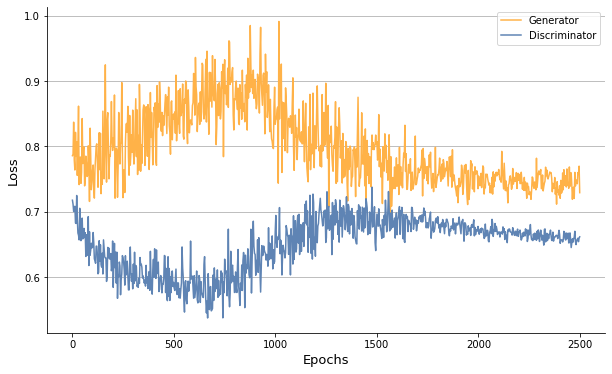

In [107]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

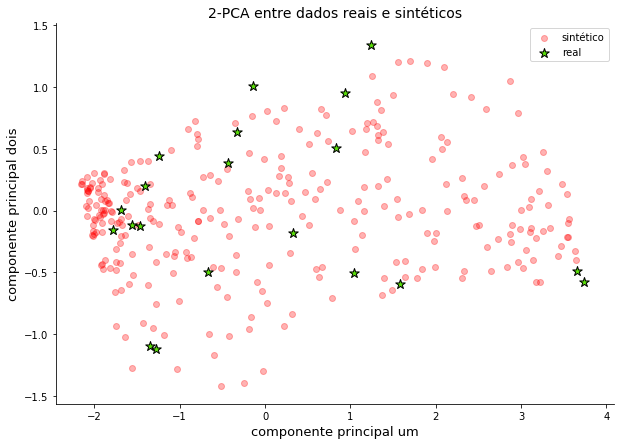

In [108]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [109]:

from sklearn.svm import OneClassSVM
#nu=0.0112

clf = OneClassSVM(kernel="rbf", nu=0.01, gamma=1/X_nov.shape[1], max_iter=-1).fit(X_nov) #0.0138

print("train recall score: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train recall score in the RG: ", recall_score(np.ones(14), clf.predict(X_train[:14])))
print("test recall score in the RG: ", accuracy_score(np.ones(6),clf.predict(X_train[14:]) ))
print("recall em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train recall score:  0.9745222929936306
train recall score in the RG:  0.7142857142857143
test recall score in the RG:  0.8333333333333334
recall em todos os genes de referência:  0.75
------------------------------------------------------


((813, 9), (3355, 9))

In [110]:
sc, df = clf.score_samples(X_nov), clf.decision_function(X_nov)


In [111]:
sc[np.where(df<0)], np.where(df<0)

(array([1.19593681, 1.19579545, 1.19598277, 1.19581266, 1.19598277,
        1.19581915, 1.19556   , 1.19598297]),
 (array([  1,   6,   7,  12,  77, 237, 252, 260]),))

In [112]:
np.sort(sc)[:len(sc[np.where(df<0)])] == np.sort(sc[np.where(df<0)])

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [113]:
min_pre = np.inf
l_dist = []
for i in range(300):
    t_i = time()
    noise_input = 50
    ep = 1700
    #Gerador
    optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
    #optimizerG = SGD(lr=0.00011, momentum=0.92)
    obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
    G = obj_G.compileG()
    # Discriminador
    optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
    #optimizerD = SGD(lr=0.001, momentum=0.9)
    objD = Discriminator((X_train.shape[1],), optimizerD)
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    w_i = gan.get_weights().copy()
    g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(50):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        d = []
        for g in range(X_train.shape[0]):
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d)))
    l_dist.append(np.mean(np.array(l_pre)))
    if np.mean(np.array(l_pre)) < min_pre:
        min_pre = np.mean(np.array(l_pre))
        w_best = w_i
    t_f = time()
    print("iteração: ",i," ", np.round(t_f-t_i,4), "[s]")

KeyboardInterrupt: 

In [0]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_338 (Sequential)  (None, 9)                 11559     
_________________________________________________________________
sequential_339 (Sequential)  (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [0]:
gan.get_weights()[0][0][0]

-0.24416424

In [0]:
gan.set_weights(w_best)
gan.get_weights()[0][0][0]

-0.18735644

In [0]:
g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.701279],[Generator::loss: 0.896895], 33.517858[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.708471],[Generator::loss: 0.845350], 0.049030[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.710123],[Generator::loss: 0.867165], 0.046022[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.706635],[Generator::loss: 0.906326], 0.050200[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.725346],[Generator::loss: 0.892688], 0.052005[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.708596],[Generator::loss: 0.785187], 0.045883[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.707538],[Generator::loss: 0.878278], 0.047631[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.721583],[Generator::loss: 0.890841], 0.038450[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.722486],[Generator::loss: 0.844270], 0.038302[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.718200],[Generator::loss: 0.806336], 0.041853[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.713599],[Generator::loss: 0.824897],

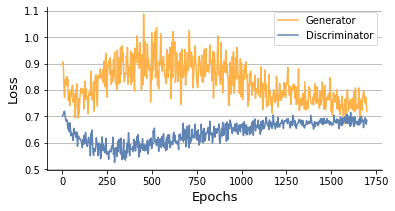

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();
plt.savefig('./drive/My Drive/Colab Notebooks/data/images/loss.svg');

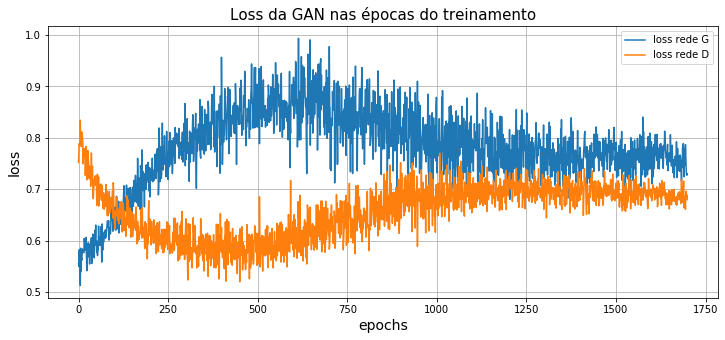

In [0]:
fig = plt.figure(figsize=(12,5))

plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

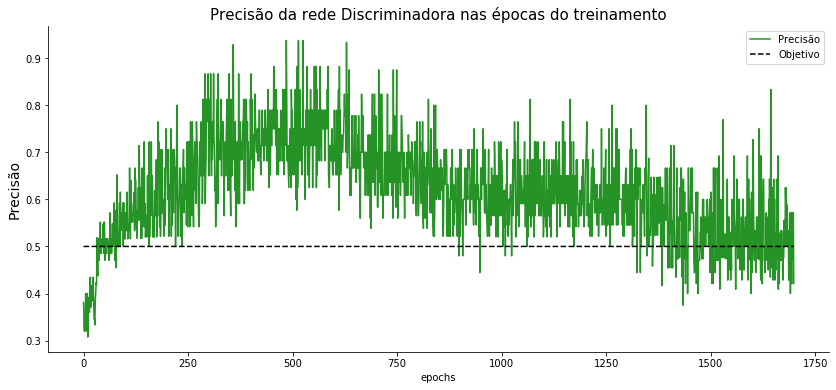

In [0]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

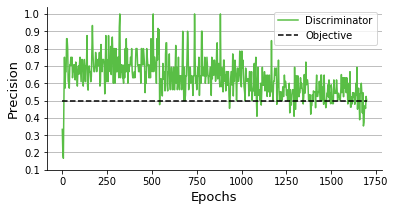

In [0]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_precision, color="#59BE45", alpha=1, label="Discriminator");
plt.plot(rr,np.ones(len(short_precision))*.5,
         color="black", ls="--", label="Objective");
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
           np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
plt.grid(axis="y")
plt.legend();
plt.savefig('./drive/My Drive/Colab Notebooks/data/images/precision.svg');

In [0]:
#gan.save("./drive/My Drive/Colab Notebooks/data/best_gan27012020.h5")

In [114]:
from tensorflow.keras.models import load_model

gan_save = load_model("./results/best_gan27012020.h5")
weights_save = gan_save.get_weights()
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()
gan.set_weights(weights_save)

Dimension del ruido de entrada:  50
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_25 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


(20, 2) (300, 2)


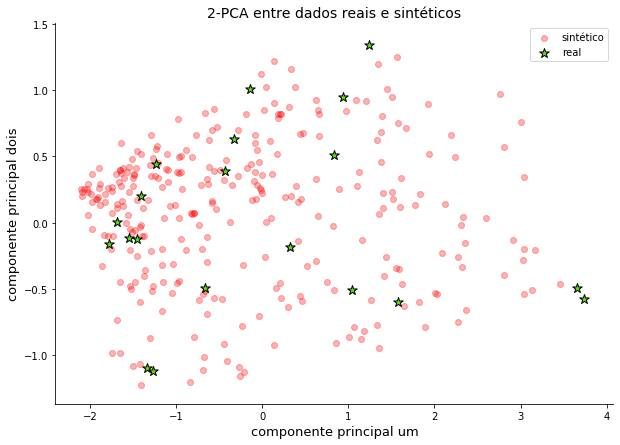

In [27]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(0, 1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [29]:
m_precision = []
m_recall = []
m_f1score = []
m_accuracy = []
t_gi = time()
for i in range(5000):
    t_i = time()
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    m_precision.append(precision_score(y_test, y_predict))
    m_recall.append(recall_score(y_test, y_predict))
    m_f1score.append(f1_score(y_test, y_predict))
    m_accuracy.append(accuracy_score(y_test, y_predict))
    if i%500 == 0:
        t_f = time()
        print ('iteration:[%d/%d], time: %f' % (i, 5000, t_f-t_i))
t_gf = time()
print("global time: ", (t_gf-t_gi)/60, "[s]")

iteration:[0/5000], time: 0.012434
iteration:[500/5000], time: 0.006527
iteration:[1000/5000], time: 0.006603
iteration:[1500/5000], time: 0.006731
iteration:[2000/5000], time: 0.006687
iteration:[2500/5000], time: 0.006684
iteration:[3000/5000], time: 0.006793
iteration:[3500/5000], time: 0.006655
iteration:[4000/5000], time: 0.007397
iteration:[4500/5000], time: 0.006786
global time:  0.5806258082389831 [s]


In [31]:
def boxtplot_values(v):
    """
    return the values to plot a boxplot with ouliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]
    
    return [lower, q25, q50, q75, upper], outliers

### Boxplot das métricas do Discriminador

In [32]:
[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(m_precision))
[rl, rq1, rq2, rq3, ru], routs = boxtplot_values(np.array(m_recall))
[fl, fq1, fq2, fq3, fu], fouts = boxtplot_values(np.array(m_f1score))
[al, aq1, aq2, aq3, au], aouts = boxtplot_values(np.array(m_accuracy))

In [33]:
cats = ["Accuray", "Precision", "F1-score"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=300,) # title="Discriminator metrics"


p.segment(cats, [aq3,pq3,fq3], cats, [au,pu,fu], line_color="black")
p.segment(cats, [al,pl,fl], cats, [aq1,pq1,fq1], line_color="black")
# boxes
p.vbar(cats, 0.4, [aq2,pq2,fq2], [aq3,pq3,fq3], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.4, [aq1,pq1,fq1], [aq2,pq2,fq2], fill_color="#3B8686", line_color="black")
# whiskers
p.rect(cats, [al,pl,fl], 0.2, 0.0001, line_color="black")
p.rect(cats, [au,pu,fu], 0.2, 0.0001, line_color="black")

p.circle([cats[0] for i in range(len(np.unique(aouts)))], np.unique(aouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[1] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[2] for i in range(len(np.unique(fouts)))], np.unique(fouts),
         size=6, color="#F38630", fill_alpha=0.6)

p.legend.background_fill_alpha = 0.0
show(p)

/home/edwin/.local/lib/python3.6/site-packages/bokeh/models/plots.py:767: UserWarning: 
You are attempting to set `plot.legend.background_fill_alpha` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


In [34]:
np.arange(0.2,1,0.05)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95])

In [35]:
print("----------------------------")
print("---- accuracy metrics -----")
print("----------------------------")
print("mean accuracy: ", np.round(np.mean(m_accuracy),4))
print("median accuracy: ", np.round(np.median(m_accuracy),4))
print("std accuracy: ", np.round(np.std(m_accuracy),4))
print("----------------------------")
print("---- precision metrics -----")
print("----------------------------")
print("mean precision: ", np.round(np.mean(m_precision),4))
print("median precision: ", np.round(np.median(m_precision),4))
print("std precision: ", np.round(np.std(m_precision),4))
print("----------------------------")
print("---- recall metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_recall),4))
print("median recall: ", np.round(np.median(m_recall),4))
print("std recall: ", np.round(np.std(m_recall),4))
print("----------------------------")
print("---- f1-score metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_f1score),4))
print("median recall: ", np.round(np.median(m_f1score),4))
print("std recall: ", np.round(np.std(m_f1score),4))

----------------------------
---- accuracy metrics -----
----------------------------
mean accuracy:  0.5599
median accuracy:  0.55
std accuracy:  0.0565
----------------------------
---- precision metrics -----
----------------------------
mean precision:  0.5617
median precision:  0.5455
std precision:  0.0604
----------------------------
---- recall metrics -----
----------------------------
mean recall:  0.6
median recall:  0.6
std recall:  0.0
----------------------------
---- f1-score metrics -----
----------------------------
mean recall:  0.5786
median recall:  0.5714
std recall:  0.0316


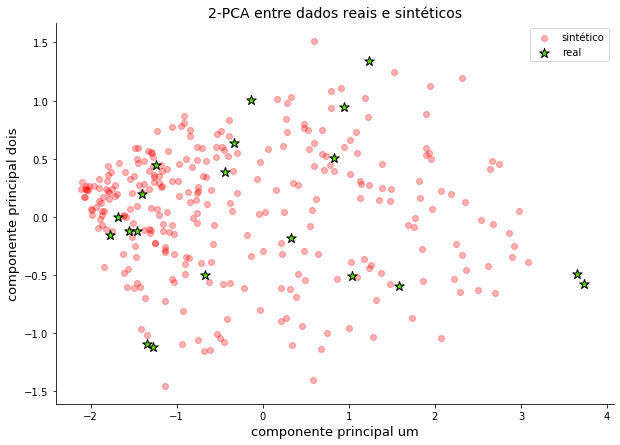

In [36]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [56]:
import tensorflow.keras.backend as K

In [58]:
K.eval(D.optimizer.lr)

0.001

In [60]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.median(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [38]:
t_i = time()
dt_cv, best_idx = best_sample(G, 300, 5000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i), "[s]")
print(dt_cv[best_idx][0], best_idx)

tempo de execuçฺão:  36.530534982681274 [s]
0.1085118012431835 2906


In [ ]:
40 s

In [61]:
c_v = []
for i in dt_cv.keys():
    c_v.append(dt_cv[i][0])

0.13397432804632814


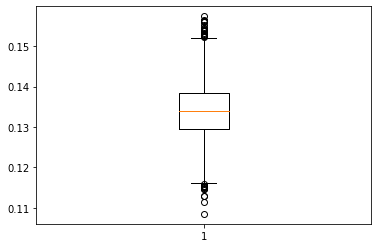

In [62]:
print(np.median(c_v))
plt.boxplot(c_v,);

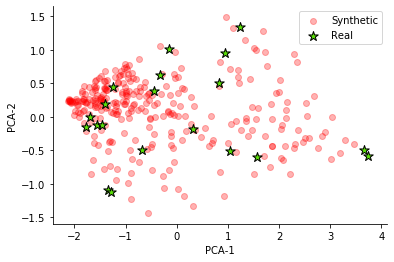

In [64]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="Synthetic", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend(loc="upper right");
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/new_data.svg');

In [65]:
#ENTRENANDO EL CLASIFICADOR SOLO CON LOS GENES DE REFERENCIA

from sklearn.svm import OneClassSVM
#nu=0.138

X_normal = X_train
clf = OneClassSVM(kernel="rbf", nu=0.0112, gamma=1/9).fit(X_normal[:14]) #0.0138

print("train accuracy: ", accuracy_score(np.ones(14),clf.predict(X_normal[:14])))
print("test accuracy in the RG: ", accuracy_score(np.ones(6),clf.predict(X_normal[14:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_normal.shape[0]),clf.predict(X_normal)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train accuracy:  0.6428571428571429
test accuracy in the RG:  0.6666666666666666
accuray em todos os genes de referência:  0.65
------------------------------------------------------


((680, 9), (3488, 9))

In [66]:
X_nov = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
X_nov.shape

(314, 9)

train accuracy in the augmented data:  0.9840764331210191
train accuracy in the RG:  0.7142857142857143
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.75
------------------------------------------------------
train accuracy in the augmented data:  0.9840764331210191
train accuracy in the RG:  0.7142857142857143
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.75
accuracy de solo datos sintéticos:  0.9786666666666667


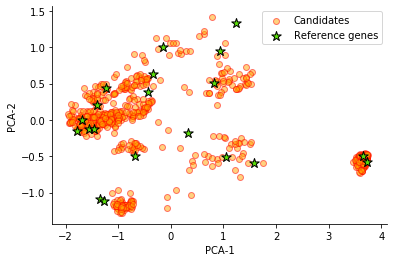

In [68]:

from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("train accuracy in the augmented data: ", accuracy_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", accuracy_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", accuracy_score(np.ones(7),clf.predict(X_train[13:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

print("train accuracy in the augmented data: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", recall_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", recall_score(np.ones(7),clf.predict(X_train[13:])))
print("accuray em todos os genes de referência: ", recall_score(np.ones(X_train.shape[0]),clf.predict(X_train)))

print("accuracy de solo datos sintéticos: ", recall_score(np.ones(3000),
                                                          clf.predict(G.predict(np.random.normal(0, 1, (3000, noise_input))))))
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)

fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidates");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Reference genes", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/candidates.svg');

### One-class classification with SVM

In [70]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9840764331210191
score nos genes de referência de treinamento:  0.7142857142857143
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.75


In [71]:
#gan.save("./data/best_gan.h5")

In [72]:
predict_cand = clf.predict(X_cand)

In [73]:
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

((750, 9), (3418, 9))

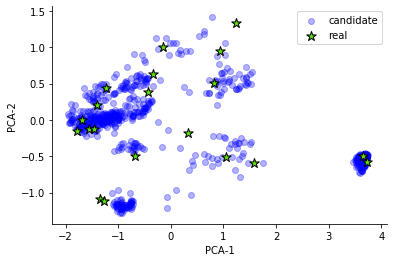

In [74]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
#plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='red', s=30, alpha=.3, label="synthetic");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
#plt.grid()
plt.legend();

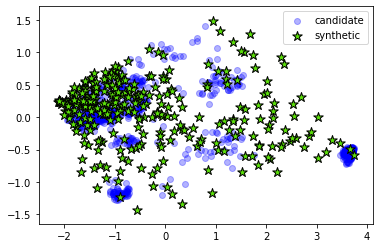

In [75]:
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='#5ADE09', s=100, alpha=1, marker="*",label="synthetic", edgecolors="black");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
#plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
plt.legend();

In [76]:
print("redução do ", (1 - cand.shape[0]/X_cand.shape[0])*100,"% no processo de escolha de candidatos")

redução do  82.00575815738964 % no processo de escolha de candidatos


In [78]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [79]:
for i in rg:
    if i in rg_moose:
        print(i)

gyrB
dnaG


In [80]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [82]:
obj_edi = open("./data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [83]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


## Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest

clf2 = IsolationForest(n_estimators=100, contamination=0, random_state=False,
                      behaviour="new", n_jobs=2, warm_start=True)
clf2.fit(X_nov)

print("score no treinamento: ", np.mean(clf2.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf2.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf2.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf2.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf2.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(2956, 9) (1229, 9)
redução do  29.70273483947682 % no processo de escolha de candidatos


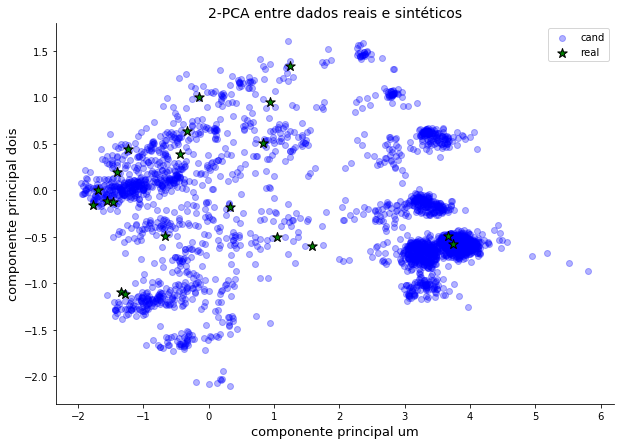

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
lhr,-1.035834,-1.041366,-1.066099,0.405957,-1.071559,-1.060662,-1.104705,-1.030697,-1.028057
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
pnp,1.012026,1.028689,-0.288030,-0.259168,-0.287101,-0.396191,0.954108,0.772673,0.990685


In [0]:
print(cand.loc[rg_edi].dropna().shape[0])
cand.loc[rg_edi].dropna()

12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
efp,0.883929,0.893426,0.986886,0.953313,0.964894,0.900637,-0.666888,0.658397,0.797629
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
polA,0.657993,0.637631,0.712010,0.686595,0.690273,-0.891506,0.583032,-0.902868,0.601666
prc,0.701789,0.687073,0.768016,0.716171,0.720595,0.659306,-0.893690,-0.953165,0.564771
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
rimP,-0.661678,0.776155,0.880130,0.877383,0.870669,0.813908,0.679395,0.567525,-0.761204
rpsO,0.938523,0.932230,-0.408265,-0.417435,-0.436328,0.963185,0.966226,0.727576,0.862091


## LocalOutlierFactor

In [0]:
from sklearn.neighbors import LocalOutlierFactor

clf3 = LocalOutlierFactor(n_neighbors=2, contamination=0.00001, novelty=True,)
clf3.fit(X_nov)

print("score no treinamento: ", np.mean(clf3.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf3.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf3.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf3.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf3.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(3344, 9) (841, 9)
redução do  20.4756242568371 % no processo de escolha de candidatos


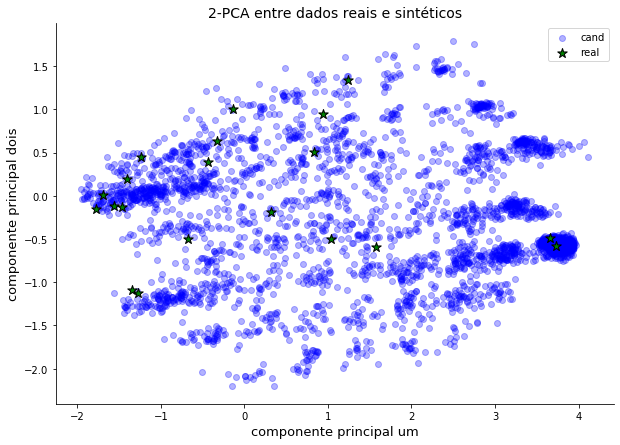

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
print(cand.loc[rg_edi].dropna().shape[0])

21
17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
